In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_fscore_support
import Scripts.Data_Read_Prepare as Data_Prepare
import Scripts.Fake_News_Detection_SVM as SVM_classifier
import Scripts.Fake_News_Detection_PA as PA_classifier
import Scripts.Fake_News_Detection_XGBoost as XGBoost_classifier
import Scripts.Fake_News_Detection_LSTM as LSTM_classifier
import Scripts.Fake_News_Detection_BiLSTM as BiLSTM_classifier
import Scripts.Fake_News_Detection_Stacked_MLP as MLP_classifier

Loading data from datasets

In [2]:
data_train, data_valid, data_test = Data_Prepare.read_data()
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
data_train = Data_Prepare.combine_classes(data_train)
data_valid = Data_Prepare.combine_classes(data_valid)
data_test = Data_Prepare.combine_classes(data_test)

Preproccesing

In [4]:
data_train, data_valid, data_test = Data_Prepare.do_preprocessing(data_train, data_valid, data_test)

data_preprocessing done!


In [5]:
data_train['label'].value_counts(normalize='true')

1    0.561719
0    0.438281
Name: label, dtype: float64

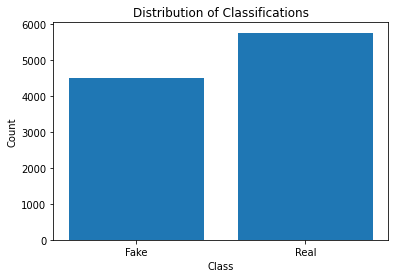

In [6]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(data_train['label'])
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [7]:
# Combine the training and validation datasets for training
data_set_all = pd.concat([data_train, data_valid, data_test])
data_train_valid = pd.concat([data_train, data_valid])

X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

In [8]:
#plot_data_length(data_set_all)

Vectorizing

In [9]:
# X_train_valid_vectorized, X_test_vectorized,vocab_size, X_train_valid_sequences, X_test_sequences =Data_Prepare.tfidf_vectorizer(X_train_valid, X_test)

In [10]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid, data_test)

SMOTE

In [19]:
# X_train_valid_resampled, y_train_valid_resampled = Data_Prepare.oversampling_data(X_train_valid_vectorized,y_train_valid)
# X_train_valid_resampled_sequences = Data_Prepare.pad_sequences(X_train_valid_resampled.toarray(),
#                                                       maxlen=250, truncating='post', padding='post')

Before SMOTE: Counter({0: 7466, 1: 4058})
After SMOTE: Counter({1: 7466, 0: 7466})


## 1- SVM

In [ ]:
#Grid search
svm_predictions, svm_train_valid_predictions =SVM_classifier.svm_gridseach(X_train_t_v, y_train_valid, X_test_t_v)

In [9]:
svm_predictions, svm_train_valid_predictions =SVM_classifier.train_svm(X_train_t_v, y_train_valid, X_test_t_v)

Execution time of SVM: 68.34 seconds


In [19]:
from sklearn.svm import SVC

def train_svm(x_train, y_train, x_test):

    svm_model = SVC(C=10, gamma='scale', kernel='rbf')
    svm_model.fit(x_train, y_train)
    svm_train_valid_predictions = svm_model.predict(x_train)
    svm_predictions = svm_model.predict(x_test)
    
    return svm_predictions, svm_train_valid_predictions

In [20]:
svm_predictions, svm_train_valid_predictions =train_svm(X_train_t_v, y_train_valid, X_test_t_v)

SVM - accuracy: 0.5439121756487026
SVM - Precision: 0.4
SVM - Recall: 0.035634743875278395
SVM - F-score: 0.065439672801636


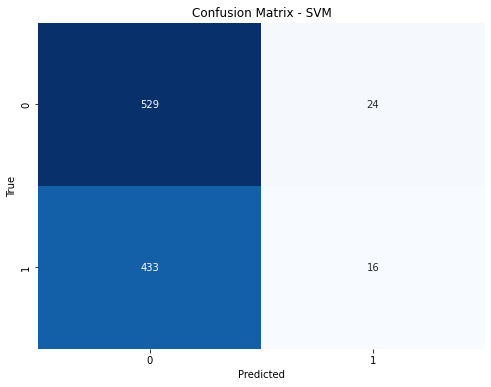

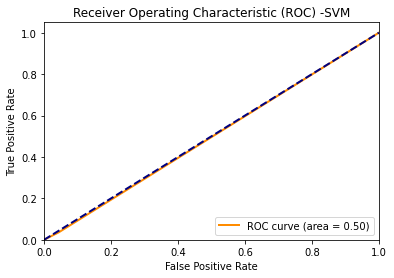

In [21]:
svm_accuracy, svm_precision, svm_recall, svm_fscore = SVM_classifier.svm_metrics(svm_predictions, y_test)
SVM_classifier.svm_confusion_matrix_plot(svm_predictions, y_test)
SVM_classifier.svm_roc_plot(svm_predictions, y_test)

## 2-Passive Aggressive

In [12]:
#Grid search with cross-validation
bla1,bla2 = PA_classifier.train_pa_gridshearch(X_train_t_v, y_train_valid)

Best Parameters: {'C': 0.1, 'fit_intercept': True, 'max_iter': 500, 'tol': 1e-07}
Best Score: 0.5144813617846746


In [11]:
PA_classifier.pa_cross_validation(X_train_t_v, y_train_valid)

Cross-Validation ROC-AUC scores: [0.48651987 0.49812775 0.51062991 0.50464265 0.45718333 0.5112915
 0.50152522 0.48405023 0.4967236  0.51215513]
Mean ROC-AUC score: 0.49628491938627983


In [21]:
from sklearn.linear_model import PassiveAggressiveClassifier

def train_pa(X_train,y_train,X_test):
    
    pa_model = PassiveAggressiveClassifier(C = 0.01, random_state = 42, max_iter=500, early_stopping=True, tol=1e-7)
    pa_model.fit(X_train, y_train)
    
    pa_train_valid_predictions = pa_model.predict(X_train)
    pa_predictions = pa_model.predict(X_test)
    y_scores = pa_model.decision_function(X_test)
    
    return pa_predictions,pa_train_valid_predictions,y_scores

In [22]:
pa_predictions,pa_train_valid_predictions,pa_scores = train_pa(X_train_t_v, y_train_valid,X_test_t_v)

In [24]:
pa_accuracy, pa_precision, pa_recall, pa_fscore = PA_classifier.pa_metrics(pa_predictions, y_test)
PA_classifier.pa_confusion_matrix_plot(pa_predictions, 3)
PA_classifier.pa_roc_plot(pa_predictions, y_test)

PA - accuracy: 0.5027624309392266
PA - Precision: 0.5697674418604651
PA - Recall: 0.4803921568627451
PA - F-score: 0.5212765957446809


TypeError: Expected sequence or array-like, got <class 'int'>

## 3-XGBoost

In [22]:
xgb_predictions, xgb_train_valid_predictions, xgb_pred = XGBoost_classifier.train_xgboost(X_train_t_v,y_train_valid, X_test_t_v,y_test)

Execution time of PA: 11.08 seconds


In [34]:
import xgboost as xgb

def train_xgboost(X_train, y_train, X_test, y_test, sample_weights):
    
#     sample_weights = X_train['weights']
#     dtrain = xgb.DMatrix(X_train.drop('weights', axis=1), label=y_train, weight=sample_weights)
#     dtest = xgb.DMatrix(X_test, label=y_test)
    
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
    }
    
    num_rounds = 400  # number of boosting rounds (iterations)     
    model = xgb.train(params, dtrain, num_rounds)
    y_pred = model.predict(dtest)

    y_train_valid_predictions = model.predict(dtrain)
    
    y_pred_binary = [1 if p >= 0.4 else 0 for p in y_pred]
    xgb_train_valid_predictions = [1 if p >= 0.4 else 0 for p in y_train_valid_predictions]
    
    return y_pred_binary, xgb_train_valid_predictions

In [35]:
sample_weights = data_train_valid['weight']
xgb_predictions, xgb_train_valid_predictions = train_xgboost(X_train_t_v,y_train_valid, X_test_t_v,y_test, sample_weights)

XGBoost - accuracy: 0.5430149960536701
XGBoost - Precision: 0.5844806007509387
XGBoost - Recall: 0.65406162464986
XGBoost - F-score: 0.6173165895571712


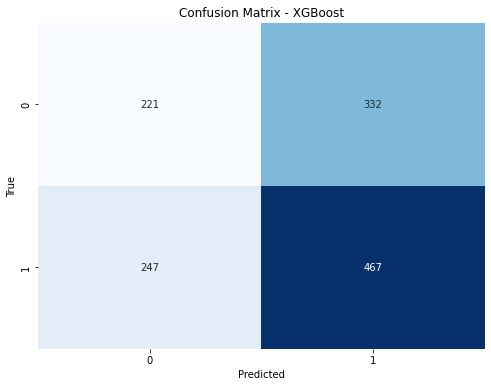

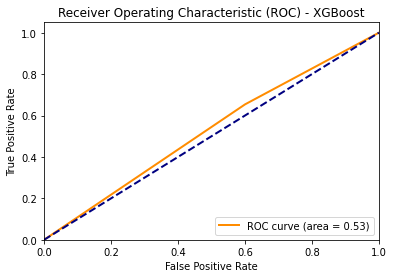

In [36]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test)

Deep Learning Preproccess

In [10]:
# X_train_tokenized,X_valid_tokenized,X_test_tokenized, vocab_size = Data_Prepare.data_tokenizer(data_train['sentence'],data_valid['sentence'],data_test['sentence'], data_set_all)

In [14]:
# embedding_matrix,X_train_word2vec, X_valid_word2vec, X_test_word2vec = Data_Prepare.word2vec_embed(X_train_tokenized,X_valid_tokenized,X_test_tokenized)

Word2Vec embedding done!


In [23]:
# X_train_sequences,X_valid_sequences,X_test_sequences=LSTM_classifier.pad_sequence_data(X_train_tokenized,X_valid_tokenized,X_test_tokenized)
# y_train = data_train['label'].values
# y_valid = data_valid['label'].values
# y_test = data_test['label'].values

In [35]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# X_train_sequences = pad_sequences(X_train_valid_resampled, maxlen=300)


## 4-LSTM

In [30]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid, data_test)

In [11]:
lstm_model, lstm_history = LSTM_classifier.train_lstm(vocab_size, embedding_matrix, X_train_t_v,
                                                      y_train_t_v,5,100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 150)          1427100   
                                                                 
 lstm_layer1 (LSTM)          (None, 300, 128)          142848    
                                                                 
 lstm_layer2 (LSTM)          (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [12]:
lstm_train_valid_predictions, lstm_predictions = LSTM_classifier.predict_lstm(lstm_model,X_train_t_v, X_test_t_v)

40/40 [==============================] - 6s 150ms/step


LSTM - Accuracy: 0.6029992107340174
LSTM - Precision: 0.5942806076854334
LSTM - Recall: 0.9313725490196079
LSTM - F-score: 0.7255864702673214


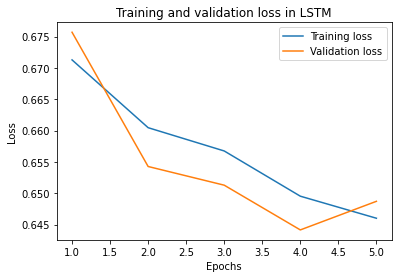

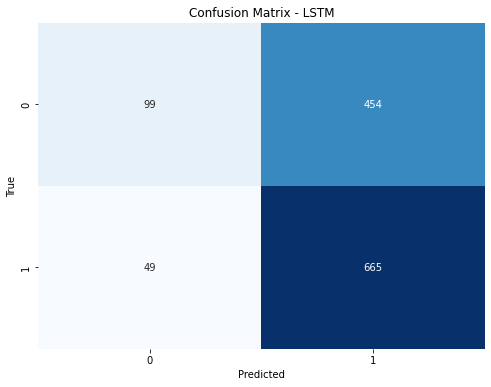

In [13]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore = LSTM_classifier.lstm_metrics(lstm_predictions, y_test_t_v)
LSTM_classifier.lstm_loss_plot(lstm_history)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v)

## 5-BiLSTM

In [8]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid, data_test)

In [9]:
bilstm_model, bilstm_history = BiLSTM_classifier.train_bilstm(vocab_size,
                                                              X_train_t_v,
                                                              y_train_t_v, 5,68)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1828950   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         285696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,283,159
Trainable params: 454,209
Non-tr

In [37]:
bilstm_train_predictions, bilstm_predictions = BiLSTM_classifier.predict_bilstm(bilstm_model,X_train_t_v, X_test_t_v)
bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore=BiLSTM_classifier.bilstm_metrics(bilstm_predictions, y_test_t_v)
BiLSTM_classifier.bilstm_loss_plot(bilstm_history)
BiLSTM_classifier.bilstm_confusion_matrix_plot(bilstm_predictions, y_test_t_v)
bilstm_roc_plot(bilstm_predictions, y_test_t_v)

40/40 [==============================] - 7s 166ms/step
BiLSTM - Accuracy: 0.4940805051302289
BiLSTM - Precision: 0.3958785249457701
BiLSTM - Recall: 0.8129175946547884
BiLSTM - F-score: 0.5324580598103574


NameError: name 'recision' is not defined

In [41]:
bilstm_accuracy= 0.4940805051302289
bilstm_precision= 0.3958785249457701
bilstm_recall= 0.8129175946547884
bilstm_fscore= 0.5324580598103574

## Evaluate Ensemblely!

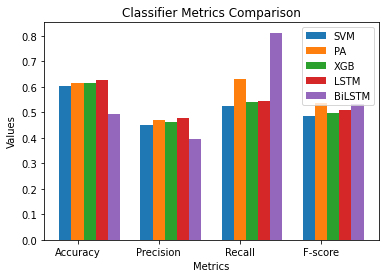

In [43]:
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [svm_accuracy, svm_precision, svm_recall, svm_fscore] 
pa=[pa_accuracy, pa_precision, pa_recall, pa_fscore]
xgb=[xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore]
lstm = [lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore] 
bilstm = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore] 

bar_width = 0.15 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, pa, bar_width, label='PA')
plt.bar(index + 2*bar_width, xgb, bar_width, label='XGB')
plt.bar(index + 3*bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 4*bar_width, bilstm, bar_width, label='BiLSTM')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

In [44]:
import numpy as np
def ensemble_prediction():   
    votes = np.array([list(row) for row in zip(svm_predictions ,xgb_predictions, pa_predictions, lstm_predictions, bilstm_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [45]:
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_ensemble, average='binary')
print("Model - accuracy:", accuracy)
print("Model - Precision:", precision)
print("Model - Recall:", recall)
print("Model - F-score:", fscore)

Model - accuracy: 0.6266771902131019
Model - Precision: 0.4793814432989691
Model - Recall: 0.621380846325167
Model - F-score: 0.5412221144519883


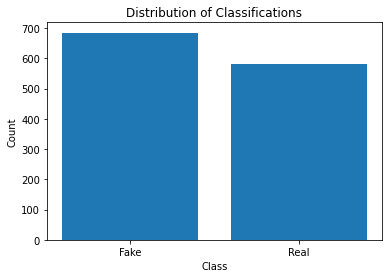

In [46]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## MLP Classifier

In [51]:
lstm_train_valid_resampled, lstm_train_valid_predictions_resampled = Data_Prepare.oversampling_data(X_train_t_v,lstm_train_valid_predictions)
# X_train_valid_resampled_sequences = Data_Prepare.pad_sequences(X_train_valid_resampled.toarray(),
#                                                       maxlen=250, truncating='post', padding='post')

Before SMOTE: Counter({0: 7001, 1: 4523})
After SMOTE: Counter({0: 7001, 1: 7001})


In [53]:
bilstm_train_resampled, bilstm_train_predictions_resampled = Data_Prepare.oversampling_data(X_train_t_v,bilstm_train_predictions)


Before SMOTE: Counter({1: 8333, 0: 3191})
After SMOTE: Counter({1: 8333, 0: 8333})


In [58]:
xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_valid_resampled.toarray(), 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
#                              lstm_train_valid_predictions_resampled.reshape((-1, 1)),
#                              bilstm_train_predictions_resampled.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))))
stacked_X_test = np.hstack((X_test_vectorized.toarray(), 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
#                             lstm_predictions.reshape((-1, 1)),
#                             bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))))


In [59]:
mlp_predictions = MLP_classifier.build_mlp(stacked_X_train, y_train_valid_resampled,stacked_X_test)

Execution time of MLP: 172.55 seconds


In [60]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))
print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       818
           1       0.45      0.52      0.48       449

    accuracy                           0.61      1267
   macro avg       0.58      0.59      0.58      1267
weighted avg       0.62      0.61      0.61      1267

MLP F-score: 0.6053670086819258
MLP Accuracy: 0.6053670086819258


In [ ]:
MLP_classifier.mlp_metrics(mlp_predictions, y_test)

In [462]:
# from sklearn.neural_network import MLPClassifier
# import time

# def build_mlp():
#     start_time = time.time()
    
#     mlp_classifier = MLPClassifier()
#     mlp_classifier.fit(stacked_X_train, y_train_valid_resampled)

#     mlp_predictions = mlp_classifier.predict(stacked_X_test)
    
#     end_time = time.time()
#     execution_time = end_time - start_time
#     print("Execution time of MLP: {:.2f} seconds".format(execution_time))
#     return mlp_predictions

In [464]:
# from sklearn.metrics import accuracy_score,f1_score, classification_report

# f_score = f1_score(y_test, mlp_predictions, average='micro')
# accuracy = accuracy_score(y_test, mlp_predictions)
# print(classification_report(y_test, mlp_predictions))
# print("Model4 - MLP F-score:", f_score)
# print("Model4 - MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       818
           1       0.48      0.51      0.50       449

    accuracy                           0.63      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.64      0.63      0.63      1267

Model4 - MLP F-score: 0.6314127861089187
Model4 - MLP Accuracy: 0.6314127861089187
